In [1]:
%load_ext autoreload
%autoreload 2

In [98]:
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import pytorch_lightning as pl
from torchinfo import summary
from sklearn.model_selection import train_test_split

from lstm_model_behavior import RecurrentAutoencoder
from lin_ae_model_behavior import LinearAutoencoder, LinearVariationalAutoencoder
from utils import plot_reach, train_model, plot_reconstruction_examples

plt.rcParams['figure.dpi'] = 100

In [50]:
PATH_ROOT = Path('/Volumes/GoogleDrive/My Drive/NMA-22/naturalistic_arm_movements_ecog')
PATH_DATA = PATH_ROOT / 'data' / 'behavior_data'

SEED = 42
pl.seed_everything(SEED)

DTYPE = torch.float
DEVICE = torch.device("mps")

DATASET = np.load(PATH_DATA / "reaches_scales.npy")
DATASET = np.swapaxes(DATASET, 2, 1)[:, :75, :]

PATH_ROI = PATH_ROOT / "data" / "Naturalistic reach ECoG tfrs ROI"
METADATA = pd.read_csv(PATH_ROI / "power-roi-all-patients-metadata.csv", index_col=0)

# check the dataset shape
assert DATASET.shape == (5984, 75, 2)

Global seed set to 42


### Prepare data

In [64]:
X_train, X_test = train_test_split(DATASET, test_size=0.2, random_state=SEED)

X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=SEED)

X_train = torch.tensor(X_train, device=DEVICE, dtype=DTYPE)
X_test = torch.tensor(X_test, device=DEVICE, dtype=DTYPE)
X_val = torch.tensor(X_val, device=DEVICE, dtype=DTYPE)

# stack coordinates
X_train = torch.swapaxes(X_train, 2, 1).view(X_train.size(0), -1)
X_test = torch.swapaxes(X_test, 2, 1).view(X_test.size(0), -1)
X_val = torch.swapaxes(X_val, 2, 1).view(X_val.size(0), -1)

assert X_train.shape == (3829, 150)

In [44]:
import ipywidgets

def plot_reaches_widget(event):
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_reach(ax, DATASET, event)
    plt.show();

ipywidgets.interact(
    plot_reaches_widget, event=ipywidgets.IntSlider(
    min=0, max=DATASET.shape[0]-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='event', max=5983), Output()), _dom_classes=('widget-inte…

### Train models

### Linear VAE

In [91]:
lae = LinearAutoencoder(150, n_hidden=5)
summary(lae, (1, 150), col_names=["input_size", "output_size", "num_params"]) 

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LinearAutoencoder                        [1, 150]                  [1, 150]                  --
├─Sequential: 1-1                        [1, 150]                  [1, 5]                    --
│    └─Linear: 2-1                       [1, 150]                  [1, 40]                   6,040
│    └─ReLU: 2-2                         [1, 40]                   [1, 40]                   --
│    └─Linear: 2-3                       [1, 40]                   [1, 20]                   820
│    └─ReLU: 2-4                         [1, 20]                   [1, 20]                   --
│    └─Linear: 2-5                       [1, 20]                   [1, 5]                    105
├─Sequential: 1-2                        [1, 5]                    [1, 150]                  --
│    └─Linear: 2-6                       [1, 5]                    [1, 20]                   120
│    └─ReLU: 2-7             

In [102]:
train_model(
    lae, X_train, X_val, X_test, n_epochs=20, batch_size=20, 
    add_to_log_name=['n_latent', 'lr'])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/LinearAutoencoder_lr=0.005

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 7.0 K 
1 | decoder | Sequential | 7.1 K 
---------------------------------------
14.1 K    Trainable params
0         Non-trainable params
14.1 K    Total params
0.056     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/anaconda3/envs/Neuromatch_2022_EcoG_movements/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/Neuromatch_2022_EcoG_movements/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/anaconda3/envs/Neuromatch_2022_EcoG_movements/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



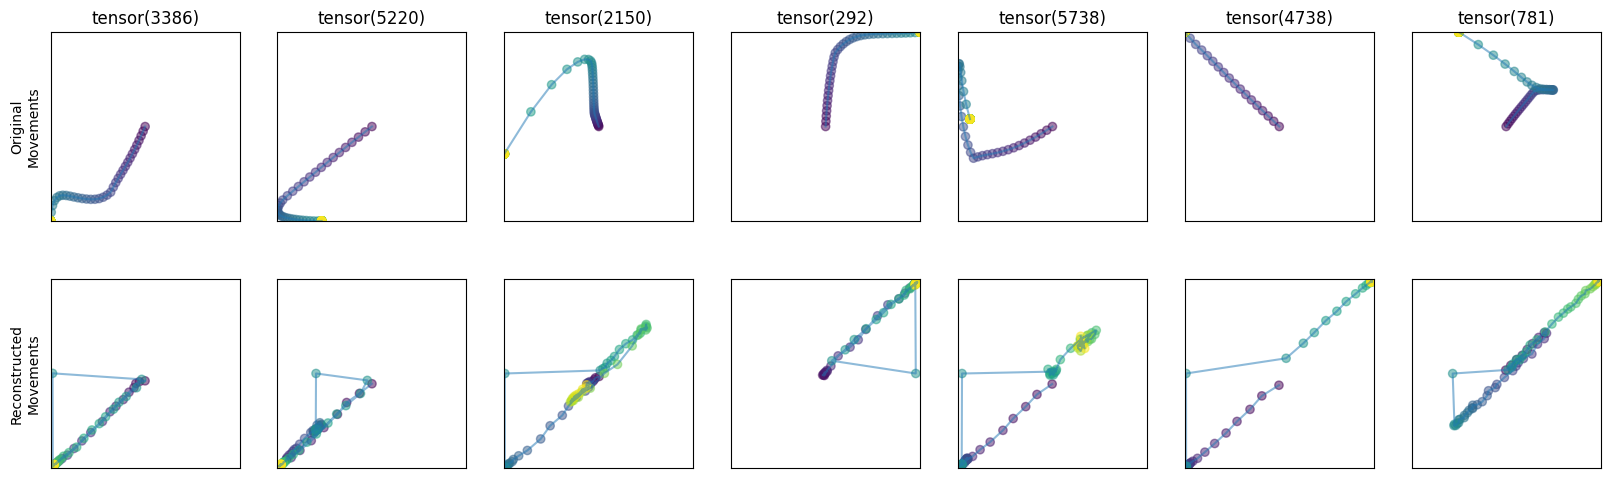

In [105]:
plot_reconstruction_examples(lae, DATASET, 7)

In [99]:
lvae = LinearVariationalAutoencoder(150, n_latent=5)

summary(lvae, (1, 75 * 2), col_names=["input_size", "output_size", "num_params"]) 

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LinearVariationalAutoencoder             [1, 150]                  [1, 150]                  --
├─Sequential: 1-1                        [1, 150]                  [1, 16]                   --
│    └─Linear: 2-1                       [1, 150]                  [1, 128]                  19,328
│    └─ReLU: 2-2                         [1, 128]                  [1, 128]                  --
│    └─Linear: 2-3                       [1, 128]                  [1, 64]                   8,256
│    └─ReLU: 2-4                         [1, 64]                   [1, 64]                   --
│    └─Linear: 2-5                       [1, 64]                   [1, 16]                   1,040
├─Linear: 1-2                            [1, 16]                   [1, 5]                    85
├─Linear: 1-3                            [1, 16]                   [1, 5]                    85
├─Linear: 1-4            

In [59]:
train_model(
    lvae, X_train, X_val, X_test, n_epochs=100, batch_size=20, 
    add_to_log_name=['n_latent', 'lr'])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/LinearVariationalAutoencoder_lr=0.01

  | Name        | Type       | Params
-------------------------------------------
0 | encoder     | Sequential | 28.6 K
1 | decoder     | Sequential | 28.8 K
2 | fc_mu       | Linear     | 85    
3 | fc_var      | Linear     | 85    
4 | decoder_inp | Linear     | 96    
-------------------------------------------
57.6 K    Trainable params
0         Non-trainable params
57.6 K    Total params
0.231     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.25053727626800537
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


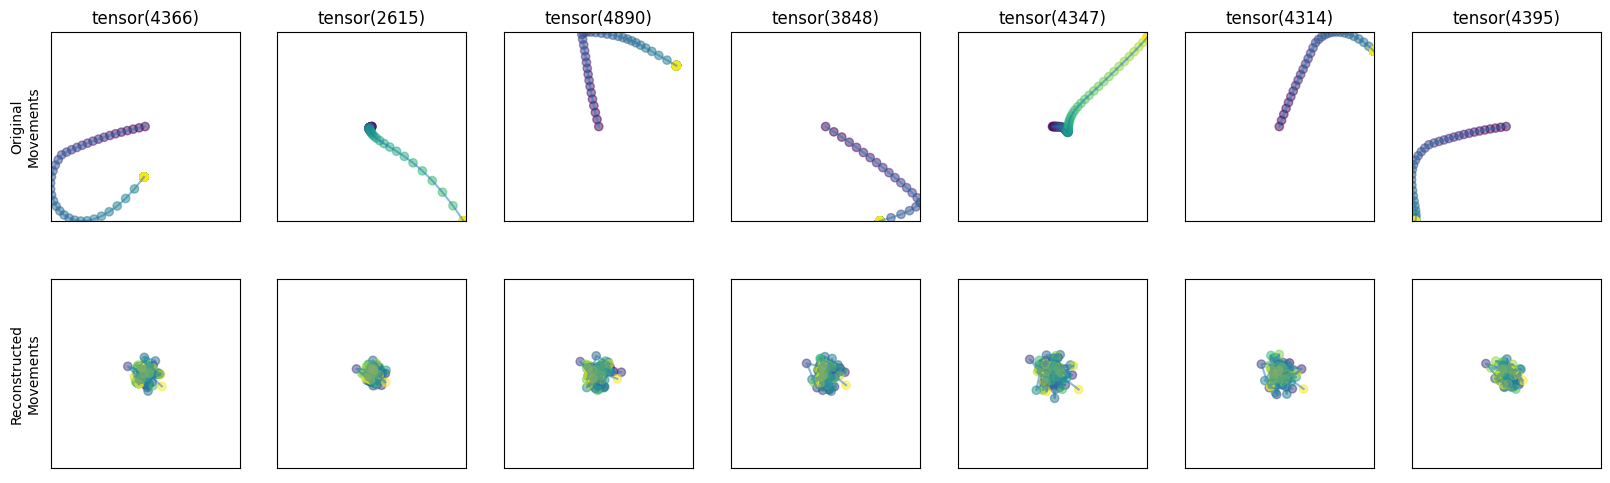

In [106]:
plot_reconstruction_examples(lvae, DATASET, 7)

In [101]:
hasattr(lvae, 'n_latent')

True

In [100]:
lvae.n_latent

5